In [1]:
import io
import json
import os.path
import theano as th
import numpy as np
import PIL.Image as img
import matplotlib.pyplot as plt
from pylearn2.utils.serial import load as load_model
from pylearn2.gui.get_weights_report import get_weights_report
import neukrill_net.image_directory_dataset as idd
import neukrill_net.encoding as enc
from IPython.display import display, Image
%matplotlib inline

Using gpu device 0: Tesla K20c


In [41]:
MODEL_PICKLE_PATH = '/home/mgraham/alexnet_based_40aug.pkl'
SETTINGS_PATH = '/home/mgraham/projects/neukrill-net-work/settings.json'
RUN_SETTINGS_PATH = '/home/mgraham/projects/neukrill-net-work/run_settings/alexnet_based_40aug.json'
WEIGHT_IMAGE_SCALE = 8
LAYER_ACTIV_SCALE = 2
N_CONV_LAYER_ROWS = 8
N_TEST_IMS = 200
SEED = 1234

In [3]:
model = load_model(os.path.expandvars(MODEL_PICKLE_PATH))

In [37]:
input_space = model.get_input_space()
input_axes = input_space.axes
input_height, input_width = input_space.shape
with open(RUN_SETTINGS_PATH, 'r') as f:
    run_settings = json.load(f)
with open(SETTINGS_PATH, 'r') as f:
    settings = json.load(f)
if run_settings.has_key('prepreprocessing'):
    prepreprocessing = run_settings['prepreprocessing']
else:
    prepreprocessing = {'resize' : [input_height, input_width], 'resize_order': 1,
                        'normalise' : run_settings['preprocessing']['normalise']}
normalise_mu = prepreprocessing['normalise']['mu']
normalise_sigma = prepreprocessing['normalise']['sigma']
prng = np.random.RandomState(SEED)

In [5]:
dataset = idd.ListDataset(transformer=lambda x: None, settings_path=SETTINGS_PATH, 
                          run_settings_path=RUN_SETTINGS_PATH, 
                          training_set_mode='test', force=True,
                          prepreprocessing=prepreprocessing)

## Model summary

In [6]:
print('## Model structure summary\n')
print(model)
params = model.get_params() 
n_params = {p.name : p.get_value().size for p in params}
total_params = sum(n_params.values())
print('\n## Number of parameters\n')
print('  ' + '\n  '.join(['{0} : {1} ({2:.1f}%)'.format(k, v, 100.*v/total_params) 
                          for k, v in sorted(n_params.items(), key=lambda x: x[0])]))
print('\nTotal : {0}'.format(total_params))

## Model structure summary

h1
	Input space: Conv2DSpace(shape=(48, 48), num_channels=1, axes=('c', 0, 1, 'b'), dtype=float32)
	Total input dimension: 2304
h2
	Input space: Conv2DSpace(shape=(21, 21), num_channels=48, axes=('b', 'c', 0, 1), dtype=float32)
	Total input dimension: 21168
h3
	Input space: Conv2DSpace(shape=(9, 9), num_channels=96, axes=('b', 'c', 0, 1), dtype=float32)
	Total input dimension: 7776
h4
	Input space: Conv2DSpace(shape=(11, 11), num_channels=128, axes=('b', 'c', 0, 1), dtype=float32)
	Total input dimension: 15488
h5
	Input space: Conv2DSpace(shape=(13, 13), num_channels=192, axes=('b', 'c', 0, 1), dtype=float32)
	Total input dimension: 32448
h6
	Input space: Conv2DSpace(shape=(8, 8), num_channels=128, axes=('b', 'c', 0, 1), dtype=float32)
	Total input dimension: 8192
y
	Input space: VectorSpace(dim=1024, dtype=float32)
	Total input dimension: 1024

## Number of parameters

  h1_W : 3072 (0.0%)
  h1_b : 80688 (0.9%)
  h2_W : 115200 (1.2%)
  h2_b : 27744 (0.3%)
 

## Train and valid set NLL trace 

Minimum validation set NLL 0.885051608086


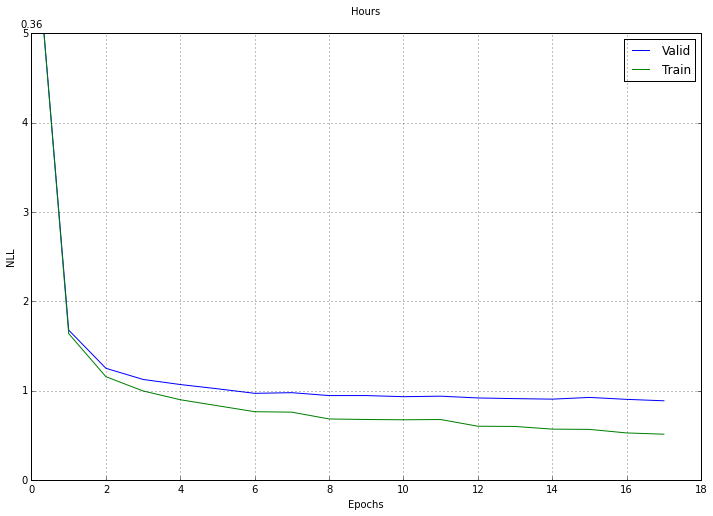

In [7]:
tr = np.array(model.monitor.channels['valid_y_nll'].time_record) / 3600.
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
ax1.plot(model.monitor.channels['valid_y_nll'].val_record)
ax1.plot(model.monitor.channels['train_y_nll'].val_record)
ax1.set_xlabel('Epochs')
ax1.legend(['Valid', 'Train'])
ax1.set_ylabel('NLL')
ax1.set_ylim(0., 5.)
ax1.grid(True)
ax2 = ax1.twiny()
ax2.set_xticks(np.arange(0,tr.shape[0],20))
ax2.set_xticklabels(['{0:.2f}'.format(t) for t in tr[::20]])
ax2.set_xlabel('Hours')
print("Minimum validation set NLL {0}".format(min(model.monitor.channels['valid_y_nll'].val_record)))

## Visualising first layer weights

smallest enc weight magnitude: 1.92526167666e-05
mean enc weight magnitude: 0.11875539273
max enc weight magnitude: 1.09314000607


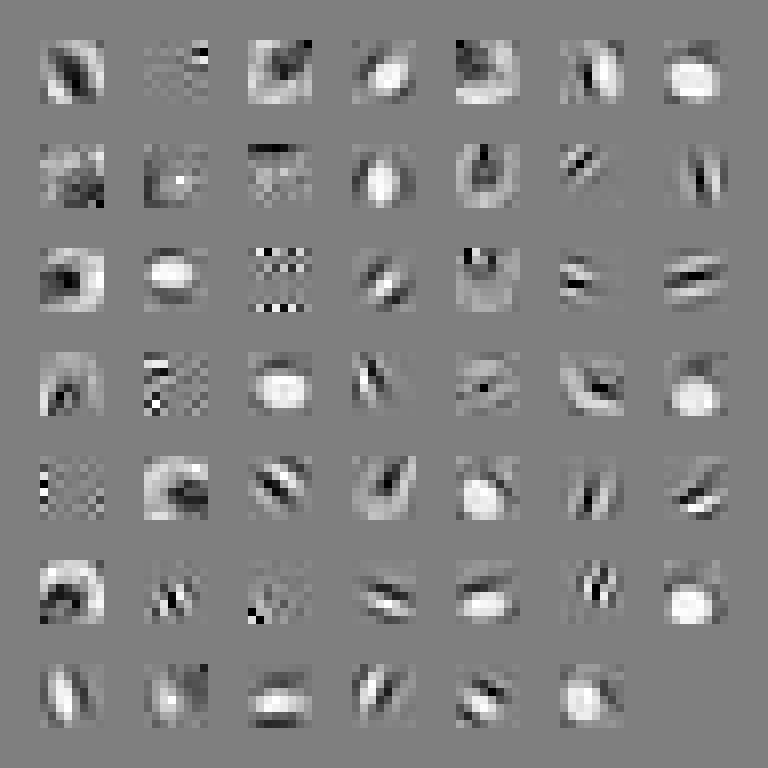

In [8]:
pv = get_weights_report(model=model)
w_img = pv.get_img()
w_img = w_img.resize((WEIGHT_IMAGE_SCALE*w_img.size[0], WEIGHT_IMAGE_SCALE*w_img.size[1]))
w_img_data = io.BytesIO()
w_img.save(w_img_data, format='png')
display(Image(data=w_img_data.getvalue(), format='png'))

## Visualising activitations for example test images

Plot an example image to check loaded correctly

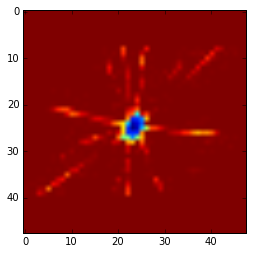

In [9]:
plt.imshow(dataset.X[0])

Compile theano function for forward propagating through network and getting all layer activations

In [10]:
X = model.get_input_space().make_theano_batch()
Y = model.fprop( X, True )
model_activ_func = th.function([X], Y)

In [12]:
test_idx = prng.choice(len(dataset.X), N_TEST_IMS, False)
input_arrs = np.array([dataset.X[i].astype(np.float32).reshape(input_height, input_width, 1) for i in test_idx])
input_arrs = (input_arrs - normalise_mu)/normalise_sigma
if input_axes == ('c', 0, 1, 'b'):
    input_arrs = input_arrs.transpose((3,1,2,0))
true_labels = [int(np.where(y)[0]) for y in dataset.y[test_idx]]
activs = model_activ_func(input_arrs)

In [13]:
def construct_activity_mosaic(layer_activ, pad=1, margin=5, n_rows=None):
    n_channels, w, h = layer_activ.shape
    if n_rows is None:
        n_rows = int(n_channels**0.5)
    n_cols = int(((1.*n_channels)/n_rows)+0.5)
    assert n_rows * n_cols >= n_channels, "n_rows * n_cols ({0}) < n_channels ({1})".format(n_rows*n_cols, n_channels)
    width = n_cols * (w + pad) - pad + 2 * margin
    height = n_rows * (h + pad) - pad + 2 * margin
    mosaic = np.ones((height, width))
    x, y = margin, margin
    r, c = 0, 0
    for i in range(n_channels):
        mosaic[y:y+h, x:x+w] = layer_activ[i].T
        x += w + pad
        c += 1
        if c == n_cols:
            c = 0
            r += 1
            y += h + pad
            x = margin
    return mosaic

In [14]:
norm_conv_activs = [activ[:,:,:,:] for activ in activs[:5]]
norm_conv_activs = [activ - activ.min(axis=(2,3))[:,:,None,None] for activ in norm_conv_activs]
norm_conv_activs = [activ / activ.max(axis=(2,3))[:,:,None,None] for activ in norm_conv_activs]
norm_fc_activ = activs[5] - activs[5].min()
norm_fc_activ = norm_fc_activ / norm_fc_activ.max()
softmax_activ = activs[-1]

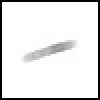

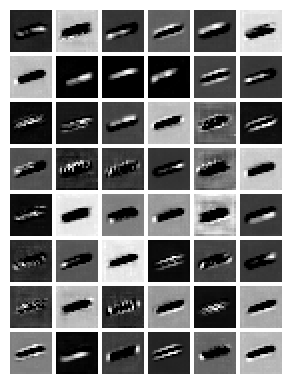

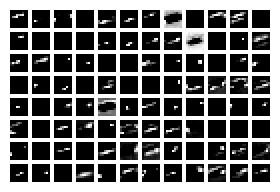

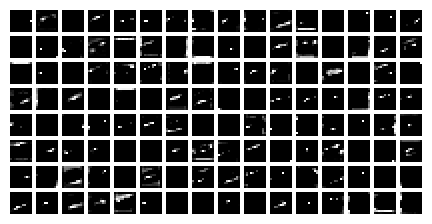

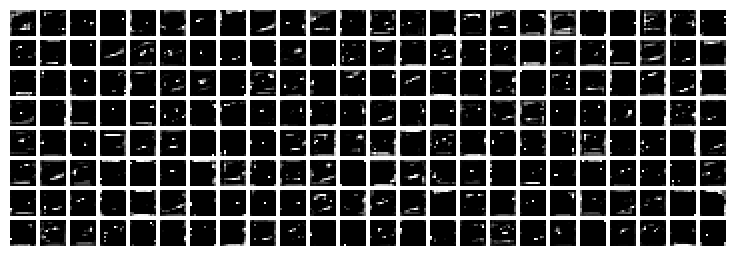

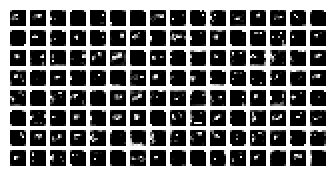

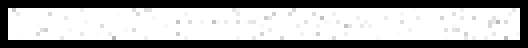

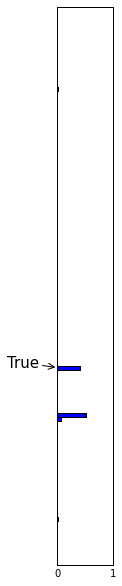

In [42]:
i = 175
true_y = true_labels[i]
# input image
input_arr = input_arrs[:,:,:,i].reshape(1, input_height, input_width) * normalise_sigma + normalise_mu
input_arr = construct_activity_mosaic(1.-input_arr, 0, 1)
input_im = img.fromarray(np.uint8((1.-input_arr)*255))
input_im = input_im.resize((LAYER_ACTIV_SCALE*input_im.size[0], LAYER_ACTIV_SCALE*input_im.size[1]))
input_data = io.BytesIO()
input_im.save(input_data, format='png')
display(Image(data=input_data.getvalue(), format='png'))
# convolutional layers
for norm_conv_activ in norm_conv_activs:
    mosaic_arr = construct_activity_mosaic(norm_conv_activ[i], 2, 5, N_CONV_LAYER_ROWS)
    mosaic_im = img.fromarray(np.uint8((mosaic_arr)*255))
    mosaic_im = mosaic_im.resize((LAYER_ACTIV_SCALE*mosaic_im.size[0], LAYER_ACTIV_SCALE*mosaic_im.size[1]))
    mosaic_data = io.BytesIO()
    mosaic_im.save(mosaic_data, format='png')
    display(Image(data=mosaic_data.getvalue(), format='png'))
# fc layer
layer_arr = construct_activity_mosaic(norm_fc_activ[i,:].reshape(-1, 16, 1), 0, 2)
layer_im = img.fromarray(np.uint8((1-layer_arr)*255))
layer_im = layer_im.resize((2*LAYER_ACTIV_SCALE*layer_im.size[0], 2*LAYER_ACTIV_SCALE*layer_im.size[1]))
layer_data = io.BytesIO()
layer_im.save(layer_data, format='png')
display(Image(data=layer_data.getvalue(), format='png'))
# softmax
fig = plt.figure(figsize=(1, 10))
ax1 = fig.add_subplot(111)
ax1.barh(np.arange(softmax_activ[i,:].shape[0]), softmax_activ[i,:], 1., fill=True)
ax1.set_xticks([0, 1.])
ax1.set_yticks([])
ax1.annotate("True", size=15,
        xy=(0.0, true_y+0.5), xycoords='data',
        xytext=(-0.9, true_y+0.5), textcoords='data',
        arrowprops=dict(arrowstyle="->",connectionstyle="arc3"),
        )
plt.show()

In [26]:
pred_labels = np.array([np.argmax(softmax_activ[i]) for i in range(len(test_idx))])

In [28]:
np.arange(len(test_idx))[pred_labels != true_labels]

array([  7,  10,  12,  14,  15,  20,  22,  24,  25,  27,  28,  32,  35,
        37,  38,  42,  45,  46,  49,  52,  55,  60,  63,  66,  68,  69,
        82,  85,  87,  88,  96,  99, 104, 105, 114, 127, 129, 135, 143,
       149, 154, 162, 166, 167, 169, 175, 183, 188, 191, 196, 197])

In [33]:
true_y

49

In [34]:
pred_labels[i]

37

In [43]:
settings['classes'][37]

u'diatom_chain_tube'